## The EM algorithm appied to the three coin problem
#### Dano Gillam

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from numba import jit
import time
%matplotlib inline

## my methods

In [2]:

@jit
def Prob(Y,X,theta): #return probability of Y given X
    lam,p1,p2 = theta
    heads,tails=X
    
    P_Xgiven_Yis1 = lam     * p1**heads * (1-p1)**tails#return probability of X given Y=1 
    P_Xgiven_Yis0 = (1-lam) * p2**heads * (1-p2)**tails#return probability of X given Y=0
    
    if Y==1: return  P_Xgiven_Yis1/(P_Xgiven_Yis1 + P_Xgiven_Yis0)
    else:   return  P_Xgiven_Yis0/(P_Xgiven_Yis1 + P_Xgiven_Yis0)

@jit    
def get_new_theta(theta,experiments,flips):
    lam=0
    p1 = 0
    p1denom = 0
    p2 = 0
    p2denom = 0
    n = len(experiments)
    for X in experiments:
        heads,tails=X
        lam +=  Prob(1,X,theta) 
        p1 += heads*Prob(1,X,theta)
        p1denom += flips*Prob(1,X,theta)
        p2 += heads*Prob(0,X,theta)
        p2denom += flips*Prob(0,X,theta)
    lam /=n
    p1 /= p1denom
    p2 /= p2denom
    return lam,p1,p2


def three_coin_problem(experiments,initial_theta=[.3,.3,.6],iterations=4,flips=3,SHOW=True):
    theta = initial_theta
    out = pd.DataFrame([theta],columns=['lambda','p1','p2'])
    for i in xrange(iterations):
        theta = get_new_theta(theta,experiments,flips)        
        out = out.append(pd.DataFrame([theta],columns=['lambda','p1','p2']),ignore_index=True)
    if SHOW:
        plt.plot(range(iterations+1),out['lambda'])
        plt.title('lambda')
        plt.ylim(0,1)
        plt.show()
        plt.plot(range(iterations+1),out['p1'])
        plt.title('p1')
        plt.ylim(0,1)
        plt.show()
        plt.plot(range(iterations+1),out['p2'])
        plt.title('p2')
        plt.ylim(0,1)
        plt.show()


    return out


def runcoinflips(theta,flips=10,trials=1000):
    '''
    Args:
        theta :[lam,p1,p2] : our probabilities
        flips (int): number of times coins are flipped after being drawn
        trials (int): number of times coins are drawn
    '''
    lam,p1,p2 = theta
    def runtrial(flips,lam):
        ps = [p1,p2]
        trial = np.zeros(flips)
        coin  = np.random.binomial(1,p=lam)
        for i in xrange(flips):
            trial[i] = np.random.binomial(1,p=ps[coin])
        return trial
    
    out = np.zeros((trials,flips))
    for i in xrange(trials):
        out[i] = runtrial(flips,lam)
    headcounts = np.sum(out,axis=1)
    return zip(headcounts,flips-headcounts)

probabilties of our coins.  
coin 0 determines which of the other coins will be flipped.  
if coin 0 is (1)heads, coin 1 is flipped  
if coin 0 is (0)tails, coin 2 is flipped


## experiment 1

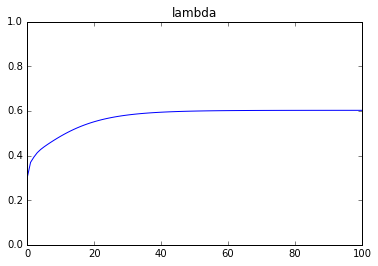

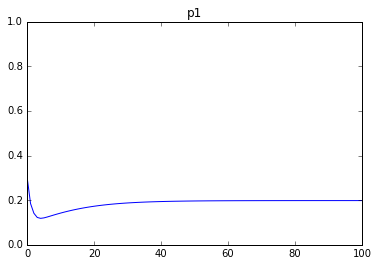

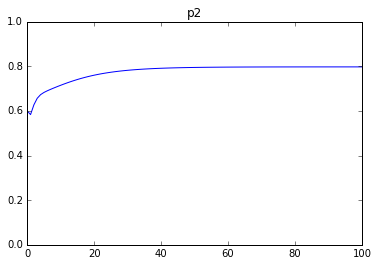

In [5]:
actual_theta = [.4,.2,.8]

experiments = runcoinflips(actual_theta,3,10000)   
experimentslist = [actual_theta[1]]*int(100*actual_theta[0]) + [actual_theta[2]]*int(100*(1-actual_theta[0]))    
tcp = three_coin_problem(experiments,iterations=100,flips=3)

### Gaussian Mixture model for the three coin problem
Notice how the gaussians converge to the actual gaussian mixture.

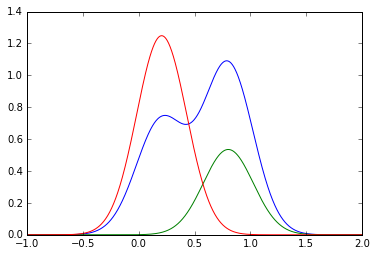

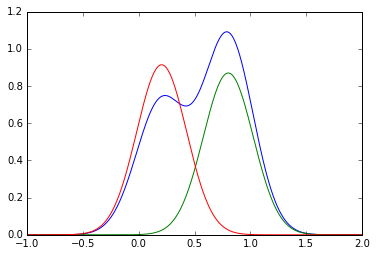

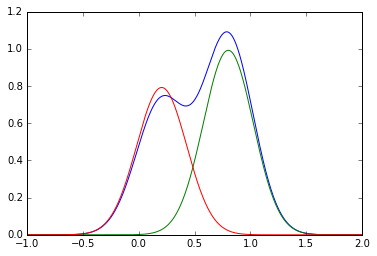

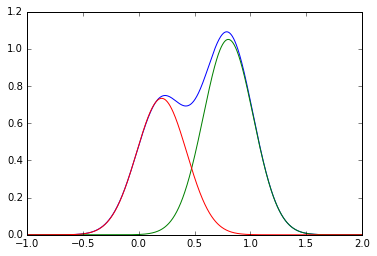

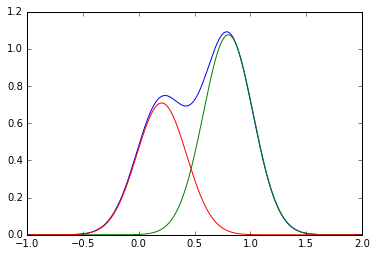

In [5]:
from scipy.stats import multivariate_normal as normal

#my kde function
def kde(M,a=-2,b=12,var=1.1):
    #Arg: M our list of data
    SIZE = 1000
    X = np.linspace(a,b,SIZE)
    Y = np.zeros(SIZE)
    for i in M:
        Y += normal.pdf(X,i,var)
    Y/=len(M)
    plt.plot(X,Y)

for i in xrange(0,50,10): 
    kde(experimentslist,-1,2,.05)
    X = np.linspace(-1,2,1000)
    plt.plot(X,normal.pdf(X,tcp['p2'].values[-1],.05)*tcp['lambda'].values[i])
    plt.plot(X,normal.pdf(X,tcp['p1'].values[-1],.05)*(1-tcp['lambda'].values[i]))
    plt.show()